Installing necessary packages and importing data.

In [129]:
load_package_quietly <- function(package) {suppressMessages(suppressWarnings(library(package, character.only = TRUE)))}
invisible(lapply(c("tidyverse", "openxlsx2", "mixOmics", "caret", "ROCR", "corrplot", "EnhancedVolcano", "pROC", "reshape2", "ComplexHeatmap", "circlize", "umap", "RColorBrewer", "ggpubr"), load_package_quietly))

pamper_microbial <- read_xlsx("~/Downloads/Research/MicroMets/Data/final_pamper.xlsx") %>%
    mutate(RESPONDER = ifelse(RESPONDER == "Resolvers", "Resolving", RESPONDER),
          RESPONDER = ifelse(RESPONDER == "NonResolvers", "Non-resolving", RESPONDER),
          RESPONDER = ifelse(RESPONDER == "EarlyNon-Survivors", "Early-Nonsurvivors", RESPONDER))
pamper_clinical <- dplyr::select(pamper_microbial, c(142:150))

swat_microbial <- read_xlsx("~/Downloads/Research/MicroMets/Data/final_swat.xlsx") %>%
    mutate(GENDER = ifelse(GENDER == 0, 1, 2)) %>%
    rename(RESPONDER = RESOLVER)
swat_clinical <- dplyr::select(swat_microbial, c(142:146))

non_normalized <- read_xlsx("~/Downloads/Research/MicroMets/Data/non_normalized.xlsx")
metabolites <- read_xlsx("~/Downloads/Research/MicroMets/Data/new_mets.xlsx")
origins <- read_xlsx("~/Downloads/Research/MicroMets/Data/Origins.xlsx")
whole <- read_xlsx("~/Downloads/Research/MicroMets/Data/whole.xlsx")

setwd("~/Downloads")

theme_nature <- function(base_size = 14, base_family = "Helvetica") {
  theme_minimal(base_size = base_size, base_family = base_family) %+replace%
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5, size = rel(1.2)),
      axis.title = element_text(face = "bold", size = rel(1.1)),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "white"),
      legend.position = "none",
      plot.background = element_rect(fill = "white", color = NA)
    )
}

sPLS-DA MicroMet extraction via VIP with nested cross-validation and an averaged ROC plot. 

In [138]:
# --- DATA PREPARATION --------------------------------------------------------
# Adjust these lines as needed for your dataset.
data <- whole[,-901] %>%
  filter(GROUP == "T24" & !is.na(RESPONDER)) %>%
  dplyr::select(-899)
data

X <- data[,-899]
Y <- factor(data$RESPONDER)

# 'origins' is assumed to be a data.frame with columns:
# "BIOCHEMICAL" and "Origin", where "Origin" flags "Microbiota".

# --- MAIN ANALYSIS -----------------------------------------------------------
n_runs <- 20

# Storage for ROC data and AUC from each run
roc_data <- list()
all_aucs <- numeric(n_runs)

# Storage for the count of microbially-associated metabolites (VIP ≥ 1) per run
selected_microbially <- numeric(n_runs)

# Storage for the actual names of microbially-associated metabolites each run
microbially_features <- vector("list", n_runs)

for (run in 1:n_runs) {
  # 1. Nested CV parameter tuning -------------------------------------------
  outer_folds <- createFolds(Y, k = 5, list = TRUE)
  
  params <- lapply(outer_folds, function(outer_train_idx) {
    X_train <- X[outer_train_idx,]
    Y_train <- factor(Y[outer_train_idx], levels = levels(Y))
    
    tune_results <- mixOmics::tune.splsda(
      X_train, Y_train,
      ncomp = 4,
      validation = "Mfold",
      folds = 3,
      progressBar = FALSE,
      measure = "BER",
      test.keepX = seq(1, 100, 1),
      nrepeat = 10
    )
    
    list(
      ncomp = tune_results$choice.ncomp$ncomp,
      keepX = tune_results$choice.keepX[[tune_results$choice.ncomp$ncomp]]
    )
  })
  
  # 2. Aggregate optimal parameters -----------------------------------------
  optimal_ncomp <- as.numeric(names(which.max(table(sapply(params, `[[`, "ncomp")))))
  optimal_keepX <- apply(do.call(rbind, lapply(params, `[[`, "keepX")), 2, median)
  
  # 3. Final model training -------------------------------------------------
  final_model <- mixOmics::splsda(X, Y, 
                                  ncomp = optimal_ncomp,
                                  keepX = optimal_keepX)
  
  # 4. ROC Calculation using pROC -------------------------------------------
  pred_array <- predict(final_model, X)$predict  # Dimensions: n x nclass x ncomp
  # For binary classification, assume the second column is the positive class
  score <- pred_array[, 2, optimal_ncomp]
  
  roc_obj <- roc(response = Y, predictor = score)
  all_aucs[run] <- auc(roc_obj)
  
  roc_spec <- roc_obj$specificities
  roc_sens <- roc_obj$sensitivities
  
  if (length(roc_spec) > 0 && length(roc_sens) > 0) {
    roc_data[[run]] <- data.frame(
      fpr = 1 - roc_spec,  # FPR = 1 - specificity
      tpr = roc_sens,
      run = factor(run)
    )
  }
  
  # 5. VIP Score Extraction -------------------------------------------------
  vip_scores <- as.data.frame(vip(final_model)) %>%
    rownames_to_column() %>%
    left_join(origins, by = c("rowname" = "BIOCHEMICAL")) %>%
    arrange(desc(comp1))
  
  vip_scores_filtered <- vip_scores[vip_scores$comp1 >= 1 & grepl("Microbiota", vip_scores$Origin), ]
  
  selected_microbially[run] <- nrow(vip_scores_filtered)
  microbially_features[[run]] <- vip_scores_filtered$rowname
}

# --- AVERAGE AUC & CONFIDENCE INTERVAL ---------------------------------------
mean_auc <- mean(all_aucs)
sd_auc   <- sd(all_aucs)
auc_95ci <- quantile(all_aucs, c(0.025, 0.975))

message(sprintf("Mean AUC across %d runs: %.3f ± %.3f", n_runs, mean_auc, sd_auc))
message(sprintf("95%% AUC CI: [%.3f, %.3f]", auc_95ci[1], auc_95ci[2]))

# --- AVERAGED ROC CURVE ------------------------------------------------------
roc_data <- roc_data[!sapply(roc_data, is.null)]
if (length(roc_data) == 0) {
  stop("No valid ROC curves were computed!")
}

common_fpr <- seq(0, 1, length.out = 100)

interp_tpr_list <- lapply(roc_data, function(d) {
  d_temp <- d[, c("fpr", "tpr")]
  d_temp <- d_temp[!duplicated(d_temp$fpr), ]
  # Force endpoints (0,0) and (1,1)
  d_temp <- rbind(data.frame(fpr = 0, tpr = 0),
                  d_temp,
                  data.frame(fpr = 1, tpr = 1))
  ord <- order(d_temp$fpr)
  approx_fun <- approxfun(d_temp$fpr[ord], d_temp$tpr[ord], method = "linear", rule = 2)
  approx_fun(common_fpr)
})

interp_tpr <- do.call(cbind, interp_tpr_list)
if (is.null(dim(interp_tpr))) {
  interp_tpr <- matrix(interp_tpr, ncol = 1)
}

plot_data <- data.frame(
  fpr      = common_fpr,
  mean_tpr = rowMeans(interp_tpr, na.rm = TRUE),
  ci_lower = apply(interp_tpr, 1, quantile, 0.025, na.rm = TRUE),
  ci_upper = apply(interp_tpr, 1, quantile, 0.975, na.rm = TRUE)
)

# Force the averaged curve endpoints
plot_data$mean_tpr[1] <- 0
plot_data$ci_lower[1] <- 0
plot_data$ci_upper[1] <- 0
plot_data$mean_tpr[nrow(plot_data)] <- 1
plot_data$ci_lower[nrow(plot_data)] <- 1
plot_data$ci_upper[nrow(plot_data)] <- 1

# --- FINAL PLOT -------------------------------------------------------------
ggplot(plot_data, aes(x = fpr, y = mean_tpr)) +
  geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper),
              fill = "#e74c3c", alpha = 0.5) +
  # Here the ROC curve line is set to red (#e74c3c)
  geom_line(color = "#e74c3c", linewidth = 1.2) +
  geom_abline(slope = 1, intercept = 0,
              linetype = "dashed", color = "gray60", linewidth = 1) +
  labs(
    x = "False Positive Rate",
    y = "True Positive Rate",
    title = sprintf("Mean ROC Curve with 95%% CI (%d Runs)", n_runs)
  ) +
  coord_equal(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_nature(base_size = 14)

# --- REPORTING MICROBIALLY-ASSOCIATED METABOLITES ---------------------------
microb_mean <- mean(selected_microbially)
microb_95ci <- quantile(selected_microbially, c(0.025, 0.975))

message(sprintf(
  "\nAverage # microbially-associated (VIP≥1) across runs: %.2f\n95%% CI: [%.2f, %.2f]",
  microb_mean, microb_95ci[1], microb_95ci[2]
))

# Print the selected metabolite names for each run to the console
for (r in seq_len(n_runs)) {
  feat_list <- microbially_features[[r]]
  if (length(feat_list) == 0) {
    message(sprintf("Run %d: No microbially-associated features (VIP≥1).", r))
  } else {
    message(sprintf("Run %d microbially-associated (VIP≥1):", r))
    message(paste(feat_list, collapse = ", "))
  }
  message("--------------------------------------------------")
}

(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),"(2,4 or 2,5)-dimethylphenol sulfate",(2-butoxyethoxy)acetic acid,(N(1) + N(8))-acetylspermidine,(R)-3-hydroxybutyrylcarnitine,(S)-3-hydroxybutyrylcarnitine,1'-hydroxymidazolam,"1,2,3-benzenetriol sulfate (1)",⋯,xanthosine,xanthurenate,ximenoylcarnitine (C26:1)*,xylose,zolpidem,RESPONDER,AGE,GENDER,TBI,TBI_SEVERITY
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
0.55009869,0.57757512,0.09825794,-1.2627532,-0.13133861,0.58864252,-1.38744873,-0.757359138,2.53902829,-1.01076059,⋯,-0.3905730,0.640845524,-0.657866661,0.54442716,-1.6036757,NonResolvers,59,1,2,No_TBI
0.84914293,0.73372727,1.52815055,-1.2594280,0.04194491,0.79158387,1.93825014,0.320977011,0.04575546,-0.98871397,⋯,-0.3224503,-1.056104649,0.494456175,0.50405694,-1.6256790,Resolvers,24,1,1,Mod_TBI
1.04745977,1.03600969,0.69851487,-1.0923956,-1.35859018,0.16677015,0.54738395,0.080216888,-1.71666881,-0.82947681,⋯,-0.1823984,-0.900973148,0.989338595,0.49784056,-1.4481003,Resolvers,66,2,2,No_TBI
0.43187463,0.53323902,1.27066434,-1.4481998,-0.85410832,0.43409289,0.59171189,0.421733948,-0.48037497,-1.18067456,⋯,-0.5222589,-1.253423557,0.336615556,-1.12049091,-1.8101367,Resolvers,26,1,2,No_TBI
0.58022216,0.74328042,-0.15095235,-1.5106998,-0.79733262,0.44613082,0.05400941,-0.326768790,-1.30288366,-0.07095107,⋯,-0.5559298,0.996113095,0.533447050,0.34482322,-1.8839055,NonResolvers,61,1,2,No_TBI
-0.09335798,0.18507077,-0.36089696,-0.5199895,0.85672169,1.79354418,0.70369857,0.855430719,-1.88224497,1.44300171,⋯,0.9982162,-0.111981000,-0.487163134,-1.04214542,-1.6438271,NonResolvers,22,1,1,Sev_TBI
0.85300229,0.73870376,1.04940630,-1.2244719,1.09072743,1.32989547,1.10163775,0.361035905,-1.83047921,-0.96924601,⋯,-0.3411008,-1.038650400,-0.004126181,0.53682823,-1.5697689,NonResolvers,23,2,1,Sev_TBI
0.21354166,0.21276405,0.58486003,0.3723287,-0.18213071,0.68154816,0.41316115,1.448216014,-2.27024348,-1.39696010,⋯,-0.2714638,-0.236785990,-0.208681053,0.36459993,-2.0058854,NonResolvers,69,1,1,Sev_TBI
1.23147738,1.19989929,1.13107090,-0.3374851,-1.57176362,-0.01276049,0.34182283,-0.121844992,-1.92115705,-1.05548389,⋯,-0.4241003,-1.125246087,0.672432831,0.20097059,-1.6591027,Resolvers,26,1,1,Mild_TBI


ERROR: Error in mixOmics::tune.splsda(X_train, Y_train, ncomp = 4, validation = "Mfold", : 'X' must be a numeric matrix.


Logistic regression outcome prediction with k-fold cross validation.

In [27]:
data <- pamper_microbial[,-c(144:152)] %>%
    t() %>%
    as.data.frame() %>%
    rownames_to_column() %>%
    filter(rowname == "kynurenate" | rowname == "(N(1) + N(8))-acetylspermidine") %>% 
    # filter(rowname == "kynurenate") %>%
    column_to_rownames() %>%
    t() %>%
    as.data.frame() %>%
    cbind(pamper_clinical) %>%
    filter(GROUP == "T24" & !is.na(RESPONDER)) %>%
    mutate(RESPONDER = ifelse(RESPONDER == "NonResolvers", 1, 0)) %>%
    # dplyr::select(-c(2, 4, 7:10))
    dplyr::select(-c(3, 5, 8:11))

train_idx <- createDataPartition(data$RESPONDER, p = 0.8, list = FALSE)
train <- data[train_idx,]
test <- data[-train_idx,]

train$RESPONDER <- factor(train$RESPONDER, levels = c(0, 1), labels = c("NonResolver", "Resolver"))
test$RESPONDER <- factor(test$RESPONDER, levels = c(0, 1), labels = c("NonResolver", "Resolver"))

train_control <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# Train logistic regression model with cross-validation
cv_model <- train(RESPONDER ~ ., data = train, method = "glm", family = binomial,
                  trControl = train_control, metric = "ROC")

# Predict on the test set
predictions <- predict(cv_model, test, type = "prob")
pred <- predictions[, "Resolver"]  # Probability for "Resolver"

# AUC calculation
pred_obj <- prediction(pred, test$RESPONDER)
auc_value <- performance(pred_obj, measure = "auc")@y.values[[1]]
print(paste("AUC on test set:", auc_value))

validation <- swat_microbial %>%
    filter(TIME == 24 & !is.na(RESOLVER) & RESOLVER != "EarlyNon-Survivors") %>%
    mutate(RESOLVER = ifelse(RESOLVER == "NonResolvers", 1, 0)) %>%
    dplyr::select(-144)

validation$RESOLVER <- factor(validation$RESOLVER, levels = c(0, 1), labels = c("NonResolver", "Resolver"))

predictions <- predict(cv_model, validation, type = "prob")
pred <- predictions[, "Resolver"]

pred_obj <- prediction(pred, validation$RESOLVER)
auc_value <- performance(pred_obj, measure = "auc")@y.values[[1]]
print(paste("AUC on validation set:", auc_value))

[1] "AUC on test set: 0.782312925170068"
[1] "AUC on validation set: 0.845272904483431"


PLS-DA prediction of TBI outcomes.

$Comp1
                             AUC p-value
NonResolvers vs Resolvers 0.6063  0.3873

$Comp2
                          AUC p-value
NonResolvers vs Resolvers 0.7  0.1037



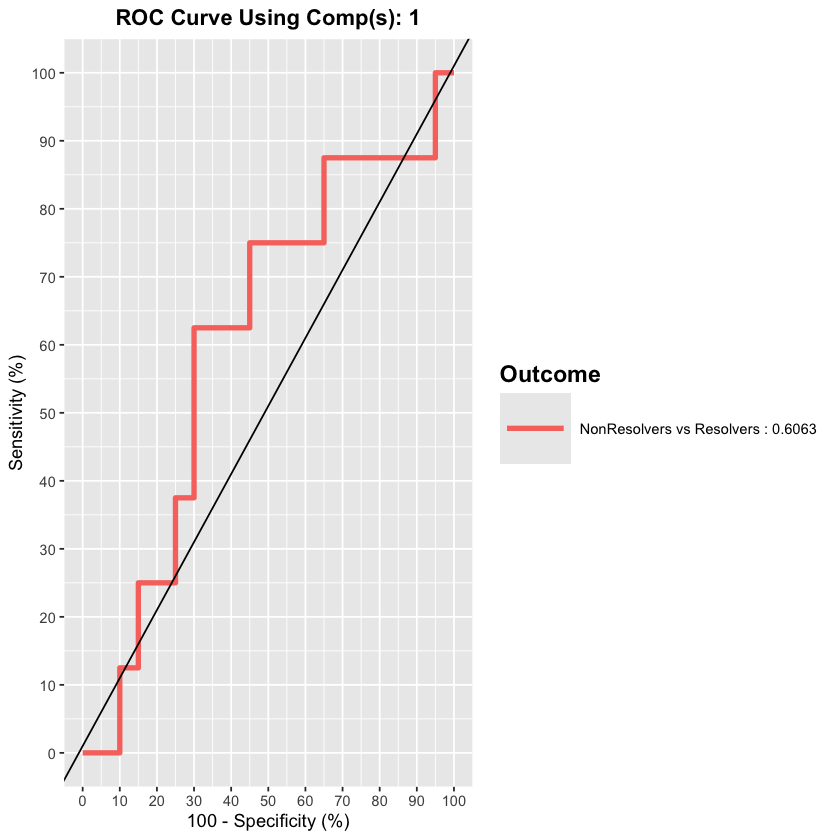

In [9]:
data <- pamper_microbial %>%
    # filter(GROUP == "T72" & !is.na(TBI) & TBI == 1) %>%
    filter(GROUP == "T24" & !is.na(RESPONDER)) %>%
    dplyr::select(-c(144, 146, 149:ncol(pamper_microbial)))

train_idx <- createDataPartition(data$RESPONDER, p = 0.8, list = FALSE)
X_train <- data[train_idx,-144]
Y_train <- data[train_idx,144]
X_test <- data[-train_idx,-144]
Y_test <- data[-train_idx,144]

tune_results <- tune.splsda(X_train, Y_train, ncomp = 3, validation = "Mfold", folds = 5,
                                progressBar = FALSE, measure = "BER",
                                test.keepX = seq(1, 150, 1), nrepeat = 20)
    
optimal_ncomp <- tune_results$choice.ncomp$ncomp
optimal_keepX <- tune_results$choice.keepX[[optimal_ncomp]]

final_model <- mixOmics::splsda(X_train, Y_train, ncomp = optimal_ncomp, keepX = optimal_keepX)
auroc(final_model, X_test, Y_test, roc.comp = 1)

# data <- pamper_microbial[,-c(144:152)] %>%
#     t() %>%
#     as.data.frame() %>%
#     rownames_to_column() %>%
#     # filter(rowname == "kynurenate" | rowname == "(N(1) + N(8))-acetylspermidine") %>%
#     filter(rowname == "kynurenate") %>%
#     column_to_rownames() %>%
#     t() %>%
#     as.data.frame() %>%
#     cbind(pamper_clinical) %>%
#     filter(GROUP == "T72" & !is.na(TBI)) %>%
#     mutate(TBI = ifelse(TBI == 1, 1, 0)) %>% # 0 represents no tbi
#     # dplyr::select(-c(144:146, 150:152))
#     dplyr::select(-c(2:4, 8:10))

# train_idx <- createDataPartition(data$TBI, p = 0.8, list = FALSE)
# train <- data[train_idx,]
# test <- data[-train_idx,]

# train$TBI <- factor(train$TBI, levels = c(0, 1), labels = c("NBI", "TBI"))
# test$TBI <- factor(test$TBI, levels = c(0, 1), labels = c("NBI", "TBI"))

# train_control <- trainControl(method = "cv", number = 10, classProbs = TRUE, summaryFunction = twoClassSummary)

# # Train logistic regression model with cross-validation
# cv_model <- train(TBI ~ ., data = train, method = "glm", family = binomial,
#                   trControl = train_control, metric = "ROC")

# # Predict on the test set
# predictions <- predict(cv_model, test, type = "prob")
# pred <- predictions[, "TBI"]  # Probability for "Resolver"

# # AUC calculation
# pred_obj <- prediction(pred, test$TBI)
# auc_value <- performance(pred_obj, measure = "auc")@y.values[[1]]
# print(paste("AUC on test set:", auc_value))

# data <- swat_microbial %>%
#     filter(TIME == 4 & !is.na(TBI)) %>%
#     mutate(TBI = ifelse(TBI == 0, "NBI", "TBI")) %>%
#     dplyr::select(-c(144:145))

# train_idx <- createDataPartition(data$TBI, p = 0.8, list = FALSE)
# X_train <- data[train_idx,-146]
# Y_train <- data[train_idx,146]
# X_test <- data[-train_idx,-146]
# Y_test <- data[-train_idx,146]

# tune_results <- tune.splsda(X_train, Y_train, ncomp = 3, validation = "Mfold", folds = 5,
#                                 progressBar = FALSE, measure = "BER",
#                                 test.keepX = seq(1, 150, 1), nrepeat = 10)
    
# optimal_ncomp <- tune_results$choice.ncomp$ncomp
# optimal_keepX <- tune_results$choice.keepX[[optimal_ncomp]]

# final_model <- mixOmics::splsda(X_train, Y_train, ncomp = optimal_ncomp, keepX = optimal_keepX)
# auroc(final_model, test, roc.comp = 1)

Volcano plot for differential metabolite analysis.

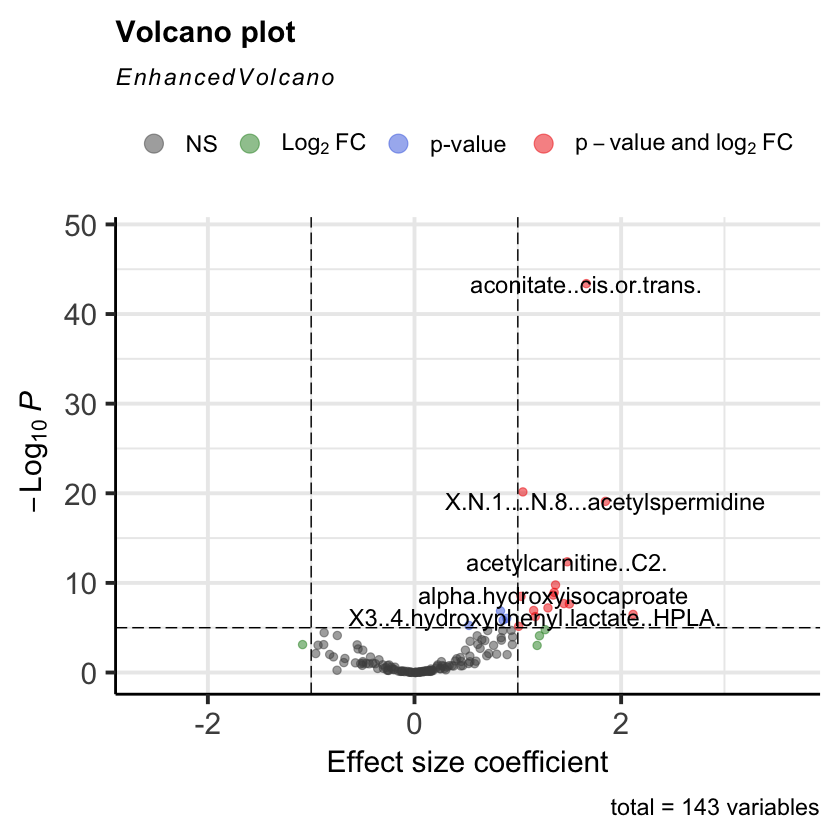

In [52]:
# effect size coefficient is just subtracting means of the two groups (i.e., resolver and nonresolver), and dividing by standard deviation
# which with autoscaled numbers is just 1. 

data <- pamper_microbial %>%
    t() %>%
    as.data.frame() %>%
    rownames_to_column() %>%
    right_join(metabolites, by = c("rowname" = "metabolites")) %>%
    column_to_rownames() %>%
    t() %>%
    as.data.frame() %>%
    cbind(pamper_clinical) %>%
    mutate(TBI = ifelse(TBI == 2, "NBI", "TBI"))
    

X <- data %>%
    filter(GROUP == "HC") %>%
    dplyr::select(-c(144:152))

Y <- data %>%
    filter(GROUP == "T0" & !is.na(TBI) & TBI == "TBI") %>%
    dplyr::select(-c(144:152))

X <- as.data.frame(lapply(X, as.numeric))
Y <- as.data.frame(lapply(Y, as.numeric))

volcano <- data.frame() %>%
    add_row()

for (i in 1:ncol(X)) {
    p <- t.test(X[,i], Y[,i])$p.value
    volcano <- mutate(volcano, !!colnames(X)[i] := p)
}

volcano <- t(volcano) %>%
    as.data.frame() %>%
    add_column()
colnames(volcano)[1] <- "pvalue"
volcano$pvalue <- p.adjust(volcano$pvalue, method = "fdr")

for (i in 1:nrow(volcano)) {
    volcano[i,2] <- mean(Y[,i]) - mean(X[,i])
}

EnhancedVolcano(volcano,
                lab = rownames(volcano),
                x = "V2",
                y = "pvalue",
               xlab = "Effect size coefficient")

# write.csv(volcano, "volcano.csv")

sPLS-DA MicroMet extraction for TBI

Setting levels: control = NBI, case = TBI

Setting direction: controls < cases



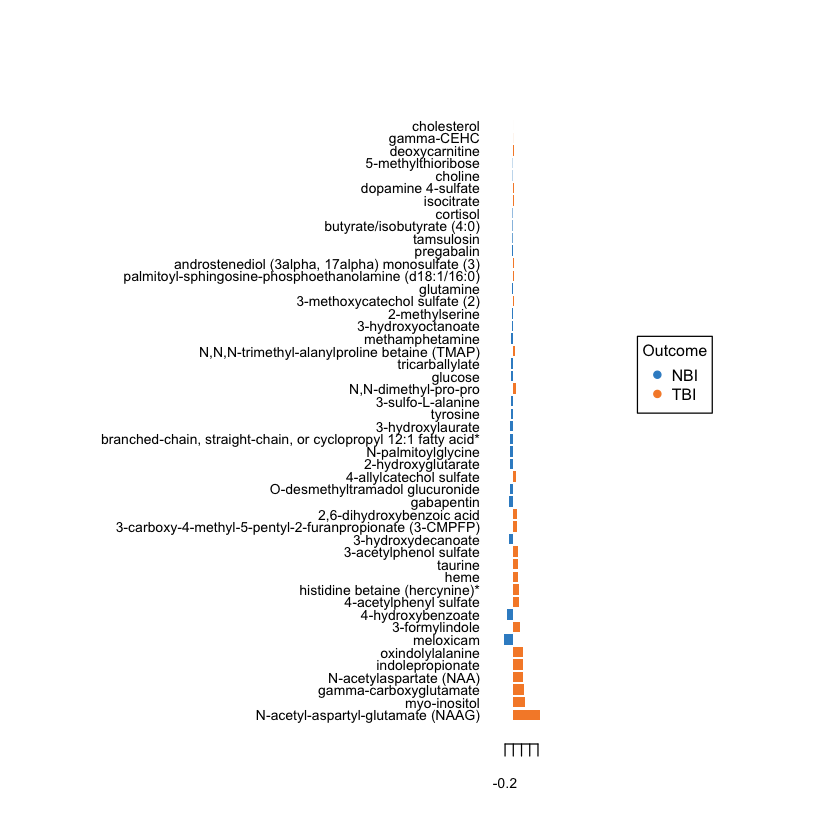

In [4]:
# --- DATA PREPARATION --------------------------------------------------------
# Adjust these lines as needed for your dataset.
data <- whole %>%
  filter(GROUP == "T0" & !is.na(TBI)) %>%
  dplyr::select(-c(899:901, 905)) %>%
  mutate(TBI = ifelse(TBI == 1, "TBI", "NBI"))

X <- data[,-901]
Y <- factor(data$TBI)

# 'origins' is assumed to be a data.frame with columns:
# "BIOCHEMICAL" and "Origin", where "Origin" flags "Microbiota".

# --- MAIN ANALYSIS -----------------------------------------------------------
n_runs <- 20

# Storage for ROC data and AUC from each run
roc_data <- list()
all_aucs <- numeric(n_runs)

# Storage for the count of microbially-associated metabolites (VIP ≥ 1) per run
selected_microbially <- numeric(n_runs)

# Storage for the actual names of microbially-associated metabolites each run
microbially_features <- vector("list", n_runs)

for (run in 1:n_runs) {
  # 1. Nested CV parameter tuning -------------------------------------------
  outer_folds <- createFolds(Y, k = 5, list = TRUE)
  
  params <- lapply(outer_folds, function(outer_train_idx) {
    X_train <- X[outer_train_idx,]
    Y_train <- factor(Y[outer_train_idx], levels = levels(Y))
    
    tune_results <- mixOmics::tune.splsda(
      X_train, Y_train,
      ncomp = 4,
      validation = "Mfold",
      folds = 3,
      progressBar = FALSE,
      measure = "BER",
      test.keepX = seq(1, 100, 1),
      nrepeat = 10
    )
    
    list(
      ncomp = tune_results$choice.ncomp$ncomp,
      keepX = tune_results$choice.keepX[[tune_results$choice.ncomp$ncomp]]
    )
  })
  
  # 2. Aggregate optimal parameters -----------------------------------------
  optimal_ncomp <- as.numeric(names(which.max(table(sapply(params, `[[`, "ncomp")))))
  optimal_keepX <- apply(do.call(rbind, lapply(params, `[[`, "keepX")), 2, median)
  
  # 3. Final model training -------------------------------------------------
  final_model <- mixOmics::splsda(X, Y, 
                                  ncomp = optimal_ncomp,
                                  keepX = optimal_keepX)
  
  # 4. ROC Calculation using pROC -------------------------------------------
  pred_array <- predict(final_model, X)$predict  # Dimensions: n x nclass x ncomp
  # For binary classification, assume the second column is the positive class
  score <- pred_array[, 2, optimal_ncomp]
  
  roc_obj <- roc(response = Y, predictor = score)
  all_aucs[run] <- auc(roc_obj)
  
  roc_spec <- roc_obj$specificities
  roc_sens <- roc_obj$sensitivities
  
  if (length(roc_spec) > 0 && length(roc_sens) > 0) {
    roc_data[[run]] <- data.frame(
      fpr = 1 - roc_spec,  # FPR = 1 - specificity
      tpr = roc_sens,
      run = factor(run)
    )
  }
  
  # 5. VIP Score Extraction -------------------------------------------------
  vip_scores <- as.data.frame(vip(final_model)) %>%
    rownames_to_column() %>%
    left_join(origins, by = c("rowname" = "BIOCHEMICAL")) %>%
    arrange(desc(comp1))
  
  vip_scores_filtered <- vip_scores[vip_scores$comp1 >= 1 & grepl("Microbiota", vip_scores$Origin), ]
  
  selected_microbially[run] <- nrow(vip_scores_filtered)
  microbially_features[[run]] <- vip_scores_filtered$rowname
}

# --- AVERAGE AUC & CONFIDENCE INTERVAL ---------------------------------------
mean_auc <- mean(all_aucs)
sd_auc   <- sd(all_aucs)
auc_95ci <- quantile(all_aucs, c(0.025, 0.975))

message(sprintf("Mean AUC across %d runs: %.3f ± %.3f", n_runs, mean_auc, sd_auc))
message(sprintf("95%% AUC CI: [%.3f, %.3f]", auc_95ci[1], auc_95ci[2]))

# --- AVERAGED ROC CURVE ------------------------------------------------------
roc_data <- roc_data[!sapply(roc_data, is.null)]
if (length(roc_data) == 0) {
  stop("No valid ROC curves were computed!")
}

common_fpr <- seq(0, 1, length.out = 100)

interp_tpr_list <- lapply(roc_data, function(d) {
  d_temp <- d[, c("fpr", "tpr")]
  d_temp <- d_temp[!duplicated(d_temp$fpr), ]
  # Force endpoints (0,0) and (1,1)
  d_temp <- rbind(data.frame(fpr = 0, tpr = 0),
                  d_temp,
                  data.frame(fpr = 1, tpr = 1))
  ord <- order(d_temp$fpr)
  approx_fun <- approxfun(d_temp$fpr[ord], d_temp$tpr[ord], method = "linear", rule = 2)
  approx_fun(common_fpr)
})

interp_tpr <- do.call(cbind, interp_tpr_list)
if (is.null(dim(interp_tpr))) {
  interp_tpr <- matrix(interp_tpr, ncol = 1)
}

plot_data <- data.frame(
  fpr      = common_fpr,
  mean_tpr = rowMeans(interp_tpr, na.rm = TRUE),
  ci_lower = apply(interp_tpr, 1, quantile, 0.025, na.rm = TRUE),
  ci_upper = apply(interp_tpr, 1, quantile, 0.975, na.rm = TRUE)
)

# Force the averaged curve endpoints
plot_data$mean_tpr[1] <- 0
plot_data$ci_lower[1] <- 0
plot_data$ci_upper[1] <- 0
plot_data$mean_tpr[nrow(plot_data)] <- 1
plot_data$ci_lower[nrow(plot_data)] <- 1
plot_data$ci_upper[nrow(plot_data)] <- 1

# --- FINAL PLOT -------------------------------------------------------------
ggplot(plot_data, aes(x = fpr, y = mean_tpr)) +
  geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper),
              fill = "#e74c3c", alpha = 0.5) +
  # Here the ROC curve line is set to red (#e74c3c)
  geom_line(color = "#e74c3c", linewidth = 1.2) +
  geom_abline(slope = 1, intercept = 0,
              linetype = "dashed", color = "gray60", linewidth = 1) +
  labs(
    x = "False Positive Rate",
    y = "True Positive Rate",
    title = sprintf("Mean ROC Curve with 95%% CI (%d Runs)", n_runs)
  ) +
  coord_equal(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_nature(base_size = 14)

# --- REPORTING MICROBIALLY-ASSOCIATED METABOLITES ---------------------------
microb_mean <- mean(selected_microbially)
microb_95ci <- quantile(selected_microbially, c(0.025, 0.975))

message(sprintf(
  "\nAverage # microbially-associated (VIP≥1) across runs: %.2f\n95%% CI: [%.2f, %.2f]",
  microb_mean, microb_95ci[1], microb_95ci[2]
))

# Print the selected metabolite names for each run to the console
for (r in seq_len(n_runs)) {
  feat_list <- microbially_features[[r]]
  if (length(feat_list) == 0) {
    message(sprintf("Run %d: No microbially-associated features (VIP≥1).", r))
  } else {
    message(sprintf("Run %d microbially-associated (VIP≥1):", r))
    message(paste(feat_list, collapse = ", "))
  }
  message("--------------------------------------------------")
}

sPLS-DA MicroMet extraction via loadings with nested cross-validation and an averaged ROC plot. 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Setting levels: control = NonResolvers, case = Resolvers

Setting direction: controls < cases

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Warning message in cor(A[[k]], variates.A[[k]]):
“the standard deviation is zero”
Setting levels: control = NonResolvers, case = Resolvers

Setting direction: controls < cases

IOPu

# A tibble: 20 × 2
   metabolite                                    avg_importance
   <chr>                                                  <dbl>
 1 "(N(1) + N(8))-acetylspermidine"                      -0.327
 2 "3-(4-hydroxyphenyl)lactate (HPLA)"                   -0.295
 3 "acisoga"                                             -0.280
 4 "docosahexaenoylcholine"                               0.221
 5 "N-acetyl-beta-alanine"                               -0.204
 6 "kynurenate"                                          -0.197
 7 "1-carboxyethylphenylalanine"                         -0.197
 8 "arachidonoylcholine"                                  0.194
 9 "1-carboxyethylvaline"                                -0.188
10 "palmitoylcholine"                                     0.183
11 "eicosapentaenoylcholine"                              0.180
12 "1-methyladenosine"                                   -0.172
13 "5alpha-pregnan-3beta,20alpha-diol disulfate"         -0.154
14 "cortisol"        

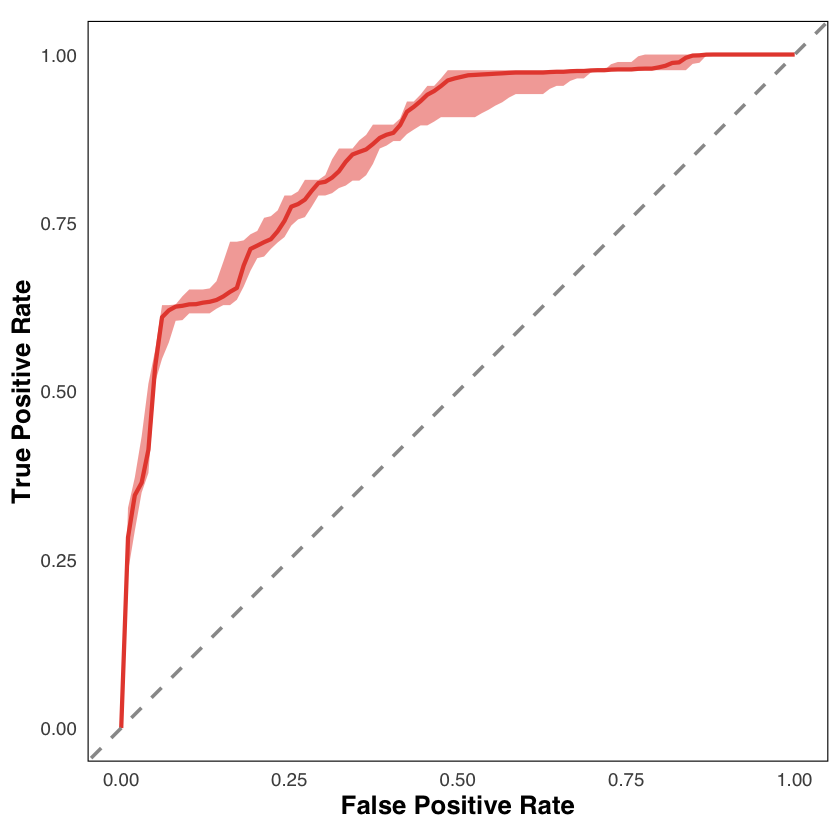

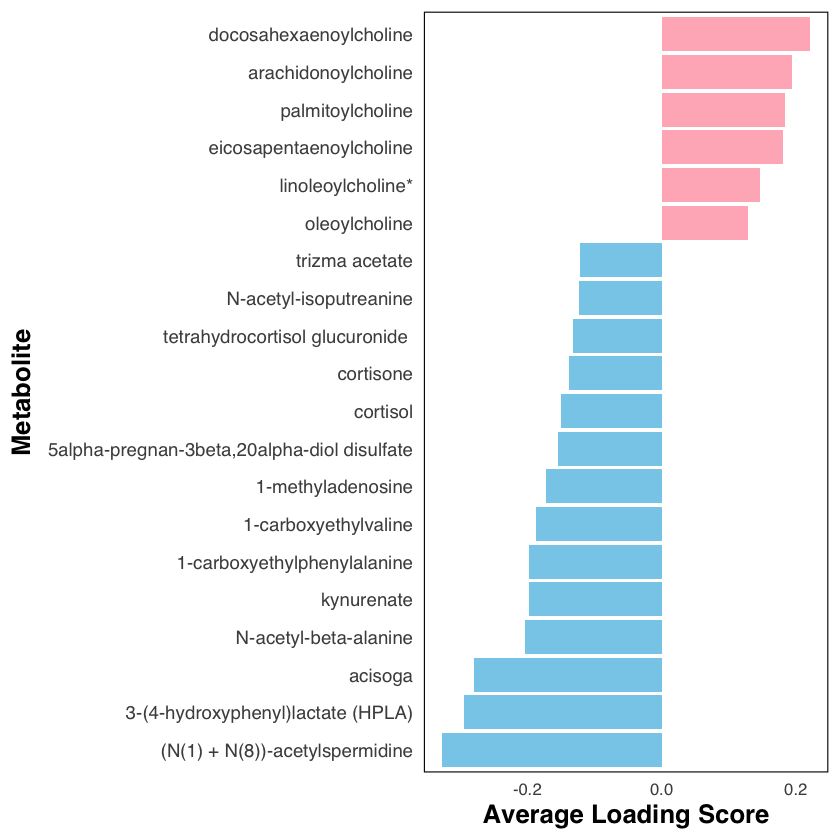

In [18]:
# --- DATA PREPARATION --------------------------------------------------------
data <- whole[,-c(901, 904:905)] %>%
  filter(GROUP == "T24" & !is.na(RESPONDER)) %>%
  dplyr::select(-899)

# X: predictors as a numeric matrix; Y: response factor
X <- data.matrix(data[,-899])
Y <- factor(data$RESPONDER)

# Get the full set of metabolites (assuming column names of X are metabolite names)
full_metabolites <- colnames(X)

# --- MAIN ANALYSIS -----------------------------------------------------------
n_runs <- 20

# Storage for ROC data and AUC from each run
roc_data <- list()
all_aucs <- numeric(n_runs)

# List to collect the raw average loading values for each metabolite for each run
importance_list <- list()

for (run in 1:n_runs) {
  # 1. Nested CV parameter tuning -------------------------------------------
  outer_folds <- createFolds(Y, k = 5, list = TRUE)
  
  params <- lapply(outer_folds, function(outer_train_idx) {
    X_train <- as.matrix(X[outer_train_idx,])  # Ensure numeric matrix
    Y_train <- factor(Y[outer_train_idx], levels = levels(Y))

  print(X_train)
    tune_results <- mixOmics::tune.splsda(
      X_train, Y_train,
      ncomp = 4,
      validation = "Mfold",
      folds = 3,
      progressBar = FALSE,
      measure = "BER",
      test.keepX = seq(1, 100, 1),
      nrepeat = 10
    )
    
    list(
      ncomp = tune_results$choice.ncomp$ncomp,
      keepX = tune_results$choice.keepX[[tune_results$choice.ncomp$ncomp]]
    )
  })
  
  # 2. Aggregate optimal parameters -----------------------------------------
  optimal_ncomp <- as.numeric(names(which.max(table(sapply(params, `[[`, "ncomp")))))
  optimal_keepX <- apply(do.call(rbind, lapply(params, `[[`, "keepX")), 2, median)
  # 3. Final model training -------------------------------------------------
  final_model <- mixOmics::splsda(as.matrix(X), Y, 
                                  ncomp = optimal_ncomp,
                                  keepX = optimal_keepX)
  
  # 4. ROC Calculation using pROC -------------------------------------------
  pred_array <- predict(final_model, X)$predict  # Dimensions: n x nclass x ncomp
  # For binary classification, assume the second column is the positive class
  score <- pred_array[, 2, optimal_ncomp]
  
  roc_obj <- roc(response = Y, predictor = score)
  all_aucs[run] <- auc(roc_obj)
  
  roc_spec <- roc_obj$specificities
  roc_sens <- roc_obj$sensitivities
  
  if (length(roc_spec) > 0 && length(roc_sens) > 0) {
    roc_data[[run]] <- data.frame(
      fpr = 1 - roc_spec,  # FPR = 1 - specificity
      tpr = roc_sens,
      run = factor(run)
    )
  }
  
  # 5. Extract raw average loadings (importance) ----------------------------
  # final_model$loadings$X should be a matrix with rownames = metabolites selected in this run.
  loading_matrix <- final_model$loadings$X
  if (!is.matrix(loading_matrix)) {
    loading_matrix <- as.matrix(loading_matrix)
  }
  
  # Compute the average loading (without taking the absolute value)
  selected_avg <- rowMeans(loading_matrix)
  
  # Create a data.frame for this run for ALL metabolites, setting unselected ones to 0
  run_importance <- data.frame(
    metabolite = full_metabolites,
    avg_loading = 0,
    run = run,
    stringsAsFactors = FALSE
  )
  # For metabolites that were selected in this run, update their average loading value
  sel_metabs <- names(selected_avg)
  idx <- match(sel_metabs, run_importance$metabolite)
  run_importance$avg_loading[idx] <- selected_avg
  
  importance_list[[run]] <- run_importance
}

# --- AVERAGE AUC & CONFIDENCE INTERVAL ---------------------------------------
mean_auc <- mean(all_aucs)
sd_auc   <- sd(all_aucs)
auc_95ci <- quantile(all_aucs, c(0.025, 0.975))

message(sprintf("Mean AUC across %d runs: %.3f ± %.3f", n_runs, mean_auc, sd_auc))
message(sprintf("95%% AUC CI: [%.3f, %.3f]", auc_95ci[1], auc_95ci[2]))

# --- AVERAGED ROC CURVE ------------------------------------------------------
roc_data <- roc_data[!sapply(roc_data, is.null)]
if (length(roc_data) == 0) {
  stop("No valid ROC curves were computed!")
}

common_fpr <- seq(0, 1, length.out = 100)

interp_tpr_list <- lapply(roc_data, function(d) {
  d_temp <- d[, c("fpr", "tpr")]
  d_temp <- d_temp[!duplicated(d_temp$fpr), ]
  # Force endpoints (0,0) and (1,1)
  d_temp <- rbind(data.frame(fpr = 0, tpr = 0),
                  d_temp,
                  data.frame(fpr = 1, tpr = 1))
  ord <- order(d_temp$fpr)
  approx_fun <- approxfun(d_temp$fpr[ord], d_temp$tpr[ord], method = "linear", rule = 2)
  approx_fun(common_fpr)
})

interp_tpr <- do.call(cbind, interp_tpr_list)
if (is.null(dim(interp_tpr))) {
  interp_tpr <- matrix(interp_tpr, ncol = 1)
}

plot_data <- data.frame(
  fpr      = common_fpr,
  mean_tpr = rowMeans(interp_tpr, na.rm = TRUE),
  ci_lower = apply(interp_tpr, 1, quantile, 0.025, na.rm = TRUE),
  ci_upper = apply(interp_tpr, 1, quantile, 0.975, na.rm = TRUE)
)

# Force the averaged curve endpoints
plot_data$mean_tpr[1] <- 0
plot_data$ci_lower[1] <- 0
plot_data$ci_upper[1] <- 0
plot_data$mean_tpr[nrow(plot_data)] <- 1
plot_data$ci_lower[nrow(plot_data)] <- 1
plot_data$ci_upper[nrow(plot_data)] <- 1

# --- FINAL PLOT: ROC CURVE --------------------------------------------------
roc_plot <- ggplot(plot_data, aes(x = fpr, y = mean_tpr)) +
  geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper),
              fill = "#e74c3c", alpha = 0.5) +
  geom_line(color = "#e74c3c", linewidth = 1.2) +
  geom_abline(slope = 1, intercept = 0,
              linetype = "dashed", color = "gray60", linewidth = 1) +
  labs(
    x = "False Positive Rate",
    y = "True Positive Rate"
    # title = sprintf("Mean ROC Curve with 95%% CI (%d Runs)", n_runs)
  ) +
  coord_equal(xlim = c(0, 1), ylim = c(0, 1)) +
  theme_nature(base_size = 14)
roc_plot
ggsave("roc_curve.pdf", plot = roc_plot, width = 6, height = 6, dpi = 600)

# --- AVERAGE METABOLITE IMPORTANCE ACROSS RUNS -----------------------------
# Combine importance values from all runs into a single data.frame
all_importances <- do.call(rbind, importance_list)

# Compute the average importance for each metabolite across runs,
# then order by the absolute value (keeping the sign).
avg_importances <- all_importances %>%
  group_by(metabolite) %>%
  summarise(avg_importance = mean(avg_loading, na.rm = TRUE)) %>%
  arrange(desc(abs(avg_importance)))

# Select the top 20 metabolites based on absolute average importance
top20_avg <- head(avg_importances, 20)
print(top20_avg)

# --- ASSIGN COLORS BASED ON EXTREMITY ---------------------------------------
# For positives, assign dark red if it's the maximum positive value, otherwise light red.
# For negatives, assign dark blue if it's the minimum (most negative) value, otherwise skyblue.
max_pos <- max(top20_avg$avg_importance[top20_avg$avg_importance > 0], na.rm = TRUE)
min_neg <- min(top20_avg$avg_importance[top20_avg$avg_importance < 0], na.rm = TRUE)

top20_avg <- top20_avg %>%
  mutate(fill_color = case_when(
    avg_importance > 0 & avg_importance == max_pos ~ "lightpink",
    avg_importance > 0 ~ "lightpink",
    avg_importance < 0 & avg_importance == min_neg ~ "skyblue",
    avg_importance < 0 ~ "skyblue",
    TRUE ~ "grey"
  ),
  # Reorder metabolites for plotting so that the largest (absolute) values appear at the top
  metabolite = reorder(metabolite, avg_importance)
  )

# --- PLOT: HORIZONTAL BAR CHART OF TOP 20 METABOLITES -----------------------
# Map x as metabolite and y as avg_importance, then flip coordinates.
metabolite_plot <- ggplot(top20_avg, aes(x = metabolite, y = avg_importance, fill = fill_color)) +
  geom_col() +
  scale_fill_identity() +
  labs(x = "Metabolite", y = "Average Loading Score") +
       # title = "Top 20 Metabolites by Average Loading (Raw Value)") +
  theme_nature(base_size = 14) +
  theme(axis.text.x = element_text(size = 10)) +
  coord_flip()
metabolite_plot
ggsave("metabolite_importance.pdf", plot = metabolite_plot, width = 8, height = 6, dpi = 300)

MicroMet Heatmap.

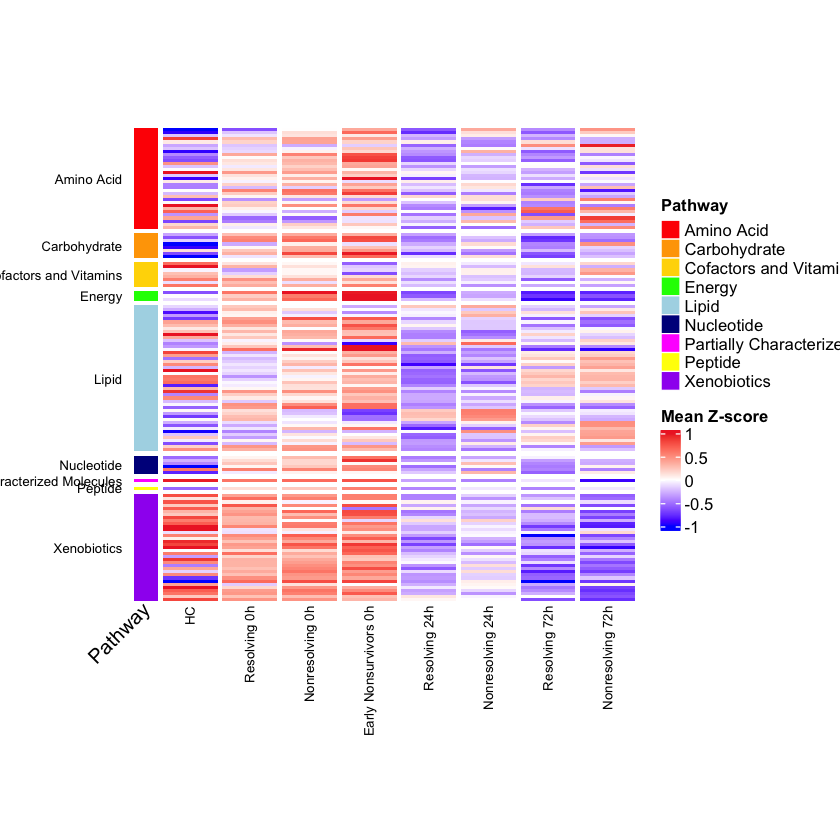

In [41]:
heatmap <- pamper_microbial %>%
  mutate(Group = TBI,
         Group = ifelse(GROUP == "HC", "HC", Group),
         Group = ifelse(GROUP == "T0" & RESPONDER == "EarlyNon-Survivors", "Early Nonsurvivors 0h", Group),
         Group = ifelse(GROUP == "T0" & RESPONDER == "Resolvers", "Resolving 0h", Group),
         Group = ifelse(GROUP == "T0" & RESPONDER == "NonResolvers", "Nonresolving 0h", Group),
         Group = ifelse(GROUP == "T24" & RESPONDER == "Resolvers", "Resolving 24h", Group),
         Group = ifelse(GROUP == "T24" & RESPONDER == "NonResolvers", "Nonresolving 24h", Group),
         Group = ifelse(GROUP == "T72" & RESPONDER == "NonResolvers", "Nonresolving 72h", Group),
         Group = ifelse(GROUP == "T72" & RESPONDER == "Resolvers", "Resolving 72h", Group)) %>%
  filter(!is.na(Group)) %>%
  dplyr::select(-c(144:152)) %>%
  group_by(Group) %>%
  summarise_all(list(mean)) %>%
  column_to_rownames("Group") %>%
  t() %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  left_join(origins, by = c("rowname" = "BIOCHEMICAL")) %>%
  dplyr::select(-c(10:14, 16)) %>%
  arrange(`SUPER PATHWAY`) %>%
  column_to_rownames("rowname")

# Specify desired order for the columns
desired_order <- c("HC", "Resolving 0h", "Nonresolving 0h", "Early Nonsurvivors 0h", 
                   "Resolving 24h", "Nonresolving 24h", "Resolving 72h", "Nonresolving 72h")

# Reorder the heatmap matrix columns using the desired order
heatmap_means <- as.matrix(heatmap[, desired_order, drop = FALSE])

annot1 <- rowAnnotation(`Pathway` = heatmap$`SUPER PATHWAY`, 
                          show_legend = TRUE, 
                          annotation_name_rot = 45,
                          col = list(`Pathway` = c("Amino Acid" = "red", 
                                                   "Peptide" = "yellow",
                                                   "Cofactors and Vitamins" = "gold",
                                                   "Carbohydrate" = "orange",
                                                   "Energy" = "green",
                                                   "Lipid" = "lightblue",
                                                   "Nucleotide" = "darkblue",
                                                   "Partially Characterized Molecules" = "magenta",
                                                   "Peptide" = "pink",
                                                   "Xenobiotics" = "purple")))

col_fun <- colorRamp2(c(-1, 0, 1), c("blue", "white", "firebrick2"))

Heatmap(heatmap_means,     
        name = "Mean Z-score",
        col = col_fun, 
        column_title = " ",
        width = unit(10, "cm"), 
        height = unit(10, "cm"),
        cluster_rows = FALSE, 
        cluster_columns = FALSE, 
        show_row_names = FALSE,
        left_annotation = annot1,
        # Use factor() to enforce the order of column splits
        column_split = factor(colnames(heatmap_means), levels = desired_order),
        row_split = heatmap$`SUPER PATHWAY`,
        row_title_rot = 0, 
        column_names_rot = 90,
        column_names_gp = grid::gpar(fontsize = 8), 
        row_title_gp = grid::gpar(fontsize = 8),
        row_gap = unit(1, "mm"))

MicroMet UMAP.

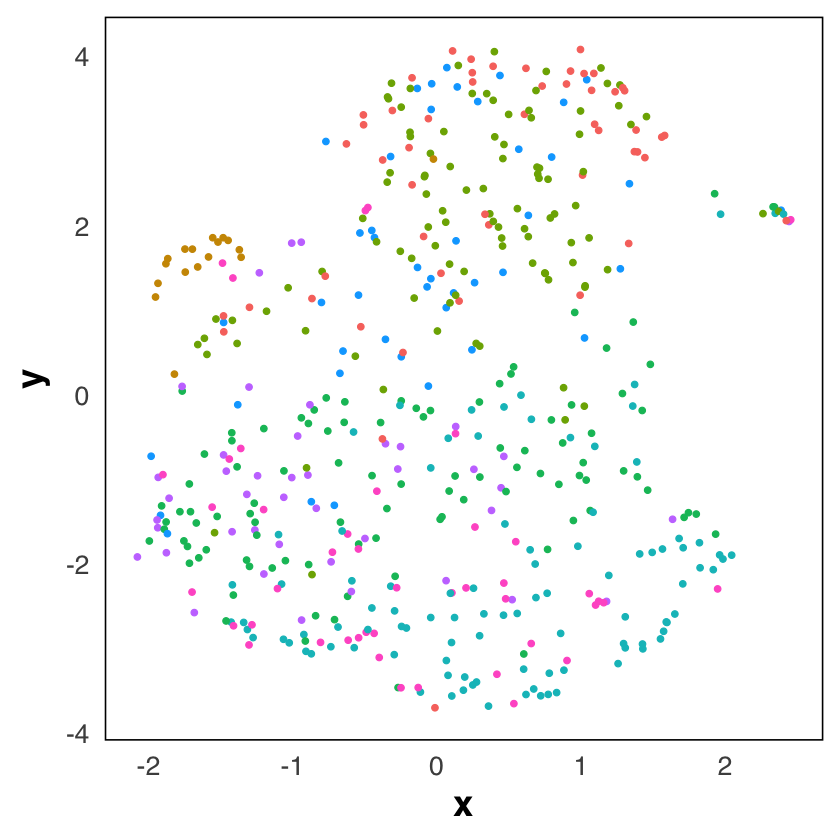

In [29]:
umap <- pamper_microbial %>%
  mutate(Group = TBI,
         Group = ifelse(GROUP == "HC", "HC", Group),
         Group = ifelse(GROUP == "T0" & RESPONDER == "EarlyNon-Survivors", "Early Nonsurvivors 0h", Group),
         Group = ifelse(GROUP == "T0" & RESPONDER == "Resolvers", "Resolving 0h", Group),
         Group = ifelse(GROUP == "T0" & RESPONDER == "NonResolvers", "Nonresolving 0h", Group),
         Group = ifelse(GROUP == "T24" & RESPONDER == "Resolvers", "Resolving 24h", Group),
         Group = ifelse(GROUP == "T24" & RESPONDER == "NonResolvers", "Nonresolving 24h", Group),
         Group = ifelse(GROUP == "T72" & RESPONDER == "NonResolvers", "Nonresolving 72h", Group),
         Group = ifelse(GROUP == "T72" & RESPONDER == "Resolvers", "Resolving 72h", Group)) %>%
  filter(!is.na(Group)) %>%
  dplyr::select(-c(144:152))
groups <- umap$Group
umap <- umap[,-144]

umap <- umap[,apply(umap, 2, var, na.rm=TRUE) != 0] %>%
    umap()

umap.df <- data.frame(x = umap$layout[,1],
                        y = umap$layout[,2],
                        time = groups)
plot <- ggplot(umap.df, aes(x, y, color = groups), frame = TRUE, frame.type = "norm") +
    geom_point() +
    theme_nature(base_size = 20)
plot
# ggsave("umap.pdf", plot, width = 8, height = 5, dpi = 800)

Plot of supervised clustering of PLS-DA.

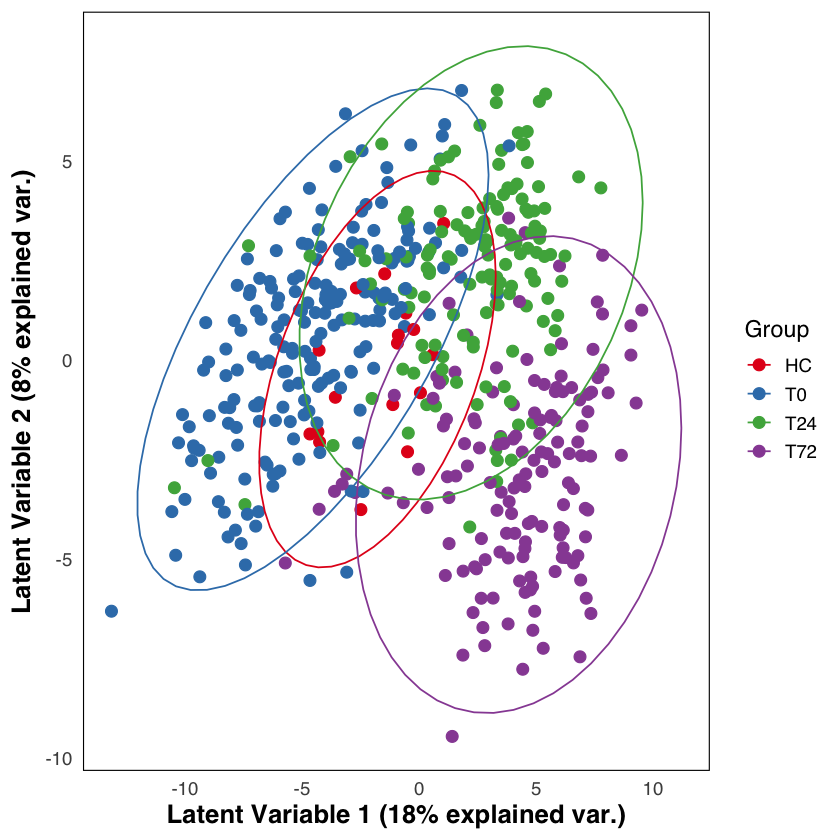

In [40]:
library(mixOmics)
library(ggplot2)

# Define your custom theme
theme_nature <- function(base_size = 14, base_family = "Helvetica") {
  theme_minimal(base_size = base_size, base_family = base_family) %+replace%
    theme(
      plot.title        = element_text(face = "bold", hjust = 0.5, size = rel(1.2)),
      axis.title        = element_text(face = "bold", size = rel(1.1)),
      panel.grid.major  = element_blank(),
      panel.grid.minor  = element_blank(),
      panel.background  = element_rect(fill = "white"),
      legend.position   = "right",  
      plot.background   = element_rect(fill = "white", color = NA)
    )
}

# Prepare your data
data <- pamper_microbial[ , -c(4, 138, 145:146, 149:152)]
data_groups <- data$GROUP
data <- data[ , -142]

# Build the PLS-DA model
model <- mixOmics::plsda(data, data_groups, ncomp = 2)

# Extract latent variable scores and ensure Group is a factor
plot_data <- data.frame(
  LV1 = model$variates$X[, 1],
  LV2 = model$variates$X[, 2],
  Group = factor(data_groups)  # <-- This fixes the issue
)

# Custom muted color palette
# muted_colors <- c("#1b9e77", "#d95f02", "#7570b3", "#e7298a")

# Create the ggplot object
p <- ggplot(plot_data, aes(x = LV1, y = LV2, color = Group, fill = Group)) +
  geom_point(size = 3) + 
  stat_ellipse(type = "norm", level = 0.95) +
  labs(
    title = NULL,
    x = "Latent Variable 1 (18% explained var.)",
    y = "Latent Variable 2 (8% explained var.)"
  ) +
  theme_nature() +
  scale_color_brewer(palette = "Set1")

# Print the plot
print(p)

Plots of MicroMet pathway differences.

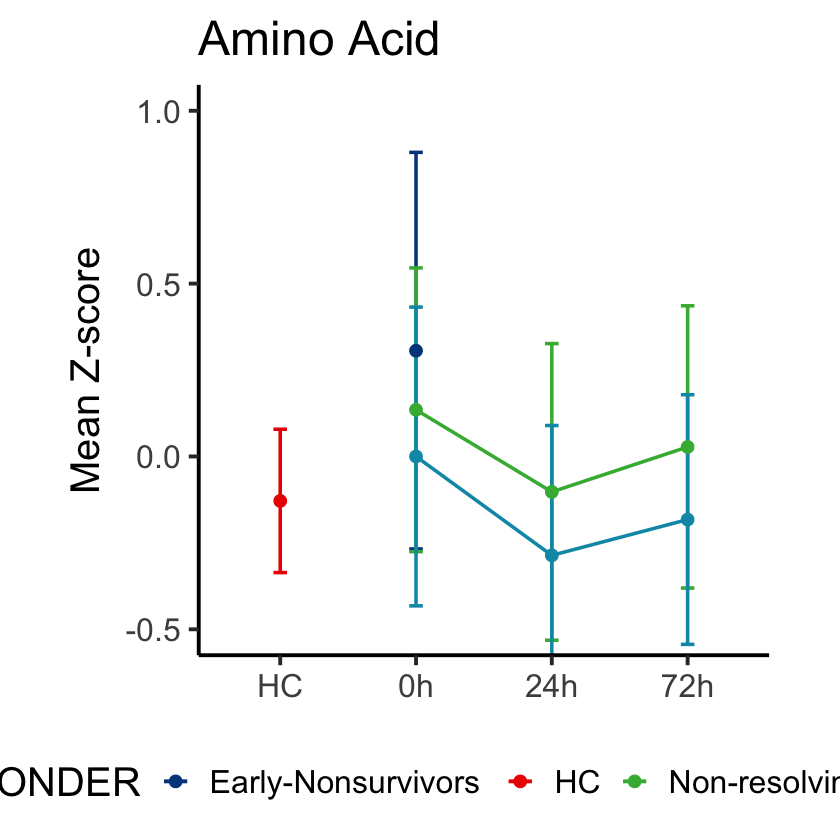

In [153]:
data <- pamper_microbial[,-c(146:152)] %>%
    filter(!is.na(RESPONDER) | GROUP == "HC") %>%
    mutate(RESPONDER = ifelse(GROUP == "HC", "HC", RESPONDER))
clin <- data[,c(144:145)]
data <- data[,-c(144:145)] %>%
    t() %>%
    as.data.frame() %>%
    rownames_to_column() %>%
    left_join(origins, by = c("rowname" = "BIOCHEMICAL")) %>%
    filter(`SUPER PATHWAY` == "Amino Acid") %>%
    dplyr::select(-c(502:508)) %>%
    column_to_rownames("rowname") %>%
    t() %>%
    as.data.frame() %>%
    cbind(clin)

# Add a sample column for identification
data$sample <- row.names(data)

# Pivot the data to long format
long_df <- data %>%
  pivot_longer(cols = -c(sample, GROUP, RESPONDER), names_to = "Metabolite", values_to = "Zscore")

# Assign all metabolites to Module 1 (for this example)
metabolites <- unique(long_df$Metabolite)
metabolite_to_module <- data.frame(Metabolite = metabolites, Module = "Amino Acid")
long_df <- long_df %>%
  left_join(metabolite_to_module, by = "Metabolite")

# Calculate the mean Z-score for Module 1 per sample
module_scores <- long_df %>%
  group_by(sample, GROUP, RESPONDER) %>%
  summarize(Zscore = mean(Zscore, na.rm = TRUE), .groups = "drop") %>%
  mutate(Module = "Amino Acid")

# Map GROUP to Time points
module_scores <- module_scores %>%
  mutate(Time = case_when(
    GROUP == "HC" ~ "HC",
    GROUP == "T0" ~ "0h",
    GROUP == "T24" ~ "24h",
    GROUP == "T72" ~ "72h"
  ))

# Define color coding for responder groups
colors <- c("HC" = "red", "Resolving" = "green", "Non-resolving" = "cyan", "Early-Nonsurvivors" = "purple")

# Define y-axis limits for Module 1 (adjust as needed)
ylim_module1 <- c(-0.5, 1.0)

# Create the plot for Module 1
p <- ggline(module_scores,
            x      = "Time",
            y      = "Zscore",
            add    = c("mean_sd"),
            size   = 1,
            point.size = 2,
            color  = "RESPONDER",
            palette = "lancet") +
     labs(title = "Amino Acid", x = NULL, y = "Mean Z-score") +
     theme_classic(base_size = 24) +
     theme(aspect.ratio = 1,
           legend.position = "bottom") +
     coord_cartesian(ylim = ylim_module1)

# # Display the plot
print(p)
# stat_summary()

ANOVAs of MicroMet pathways across time points and resolver status.